In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [68]:
CUDA = torch.cuda.is_available()
SEED = 1
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [6]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

Processing...
Done!


In [49]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [24]:
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20, out=None):
#     U = torch.rand(shape)
#     return -Variable(torch.log(-torch.log(U + eps) + eps))
    """
    Sample from Gumbel(0, 1)
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    U = out.resize_(shape).uniform_() if out is not None else torch.rand(shape)
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + Variable(sample_gumbel(logits.size(), out=logits.data.new()))
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [10]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [11]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [50]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    return gumbel_softmax(l, tau)

def signal(outputs):
    outputs = [sample(out).narrow(1,0,1) for out in outputs]
    return torch.cat(outputs, dim=1)

In [44]:
class Decoder(nn.Module):  
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)      
        self.fc4 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        o = h4.view(-1,784)
        return F.sigmoid(o)

In [45]:
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    return BCE + KLD

In [46]:
E = Encoder()
D = Decoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]

if CUDA:
    E.cuda()
    D.cuda()
    O0.cuda()
    [o.cuda() for o in Os]
    [t.cuda() for t in Ts]

In [47]:
params = [
    {'params':E.parameters()},
    {'params':D.parameters()},
    {'params':O0.parameters()},
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts]
optimizer = optim.Adam(params, lr=1e-4)

In [51]:
# training
epochs = 30

losses = []
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)
            outputs.append(Os[n](sofar))
        bits = signal(outputs)
        q = prob(outputs)
        recon_x = D(bits)
        loss = loss_function(recon_x, x, q)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    _loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch+1, _loss))
    losses.append(_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.910078
Train Epoch: 1 [20000/60000 (33%)]	Loss: 209.099414
Train Epoch: 1 [40000/60000 (67%)]	Loss: 209.693281
====> Epoch: 1 Average loss: 237.1816
Train Epoch: 2 [0/60000 (0%)]	Loss: 200.283242
Train Epoch: 2 [20000/60000 (33%)]	Loss: 205.322070
Train Epoch: 2 [40000/60000 (67%)]	Loss: 198.114492
====> Epoch: 2 Average loss: 200.2480
Train Epoch: 3 [0/60000 (0%)]	Loss: 198.987969
Train Epoch: 3 [20000/60000 (33%)]	Loss: 201.291289
Train Epoch: 3 [40000/60000 (67%)]	Loss: 198.424141
====> Epoch: 3 Average loss: 199.0987
Train Epoch: 4 [0/60000 (0%)]	Loss: 203.181836
Train Epoch: 4 [20000/60000 (33%)]	Loss: 199.727715
Train Epoch: 4 [40000/60000 (67%)]	Loss: 201.465234
====> Epoch: 4 Average loss: 198.9758
Train Epoch: 5 [0/60000 (0%)]	Loss: 199.251230
Train Epoch: 5 [20000/60000 (33%)]	Loss: 202.491113
Train Epoch: 5 [40000/60000 (67%)]	Loss: 198.986699
====> Epoch: 5 Average loss: 198.9723
Train Epoch: 6 [0/60000 (0%)]	Loss: 197.083828
Train Ep

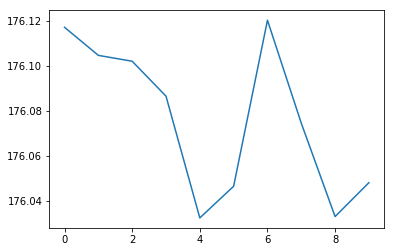

In [62]:
plt.plot(losses[-10:])

In [63]:
q

Variable containing:
( 0 ,.,.) = 
  9.9992e-01  8.3515e-05
  9.9932e-01  6.7685e-04
  5.9069e-07  1.0000e+00
  2.1739e-08  1.0000e+00
  5.0000e-01  5.0000e-01

( 1 ,.,.) = 
  5.0000e-01  5.0000e-01
  1.1591e-04  9.9988e-01
  9.1471e-01  8.5293e-02
  8.5572e-03  9.9144e-01
  5.0000e-01  5.0000e-01

( 2 ,.,.) = 
  9.9994e-01  5.5896e-05
  3.0838e-01  6.9162e-01
  4.9196e-01  5.0804e-01
  1.3672e-04  9.9986e-01
  5.0000e-01  5.0000e-01
... 

(97 ,.,.) = 
  9.9981e-01  1.8647e-04
  1.5836e-01  8.4164e-01
  9.9984e-01  1.6275e-04
  8.9437e-01  1.0563e-01
  5.0000e-01  5.0000e-01

(98 ,.,.) = 
  9.8201e-01  1.7991e-02
  9.9998e-01  1.7041e-05
  9.9991e-01  8.6852e-05
  1.0000e+00  7.1925e-07
  5.0000e-01  5.0000e-01

(99 ,.,.) = 
  5.0000e-01  5.0000e-01
  2.7796e-03  9.9722e-01
  1.2005e-05  9.9999e-01
  2.9357e-01  7.0643e-01
  5.0000e-01  5.0000e-01
[torch.cuda.FloatTensor of size 100x5x2 (GPU 0)]

In [64]:
bits

Variable containing:
    1     1     0     0     0
    1     0     1     0     0
    1     1     1     0     1
    1     1     1     1     1
    1     1     0     0     1
    1     1     0     1     0
    0     1     0     0     1
    1     0     1     1     0
    1     1     1     1     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     1     0     1     0
    1     0     1     0     1
    1     0     0     1     1
    0     1     1     1     1
    1     1     1     0     1
    1     0     0     1     0
    0     0     1     1     1
    1     1     1     0     1
    1     0     0     1     0
    0     0     1     1     1
    1     0     0     1     0
    1     1     1     1     0
    0     0     0     1     0
    0     1     1     0     0
    0     0     1     0     1
    0     0     0     1     0
    1     1     1     1     0
    1     1     0     1     1
    1     1     1     0     0
    1     0     1     0     0
    1     0     0  

In [65]:
test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

In [66]:
# a = np.array([[0., 0., 0., 0.]])
# w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
# plt.imshow(w.view(28,28).data.numpy())

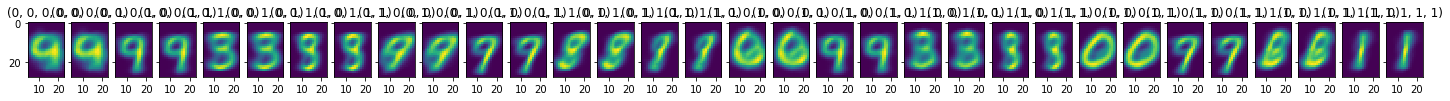

In [67]:
from itertools import product
f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
_k = 0
for path in product(range(2), repeat=N):
    data = Variable(torch.Tensor(path).type(torch.FloatTensor))
    if CUDA:
        data = data.cuda()
    w = D.forward(data)
    ax = axes[_k]
    ax.set_title(path)
    ax.imshow(w.view(28,28).cpu().data.numpy())
    _k += 1

Saved to n_5-seed_1.png


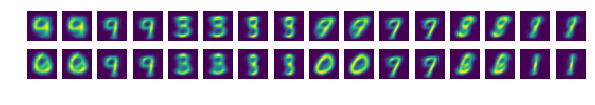

In [86]:
from itertools import product
PER_ROW = 16
N_ROW = int(2**N/PER_ROW)
f, axes = plt.subplots(N_ROW, PER_ROW, sharey=True, sharex=True, figsize=(10,0.65*N_ROW))
_k = 0
for path in product(range(2), repeat=N):
    data = Variable(torch.Tensor(path).type(torch.FloatTensor))
    if CUDA:
        data = data.cuda()
    w = D.forward(data)
    ax = axes[int(_k/PER_ROW), _k%PER_ROW]
    #ax.set_title(path)
    ax.imshow(w.view(28,28).cpu().data.numpy())
    ax.axis('off')
    
    _k += 1
    if _k % 100 == 0:
        print("{}/{} ({:.0f}%)".format(_k, 2**N, 100*_k/(2**N)))
_fname = 'n_{}-seed_{}.png'.format(N, SEED)
plt.savefig(_fname)
print("Saved to {}".format(_fname))